## Competición Kaggle II

#### Aquí encontrarás todo lo que necesitas saber: https://www.kaggle.com/competitions/reconocimiento-de-expresiones-faciales

### Librerias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential

-----------------------------------------------------------------------------------------------------------------

### Exploración de los datos

In [2]:
df_train = pd.read_csv("./data/train_set.csv")

In [3]:
df_train.head()

,id_img,path,label
0,0,../data/images/train/angry\0.jpg,angry
1,1,../data/images/train/angry\1.jpg,angry
2,10,../data/images/train/angry\10.jpg,angry
3,10002,../data/images/train/angry\10002.jpg,angry
4,10016,../data/images/train/angry\10016.jpg,angry


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28821 entries, 0 to 28820
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id_img  28821 non-null  int64 
 1   path    28821 non-null  object
 2   label   28821 non-null  object
dtypes: int64(1), object(2)
memory usage: 675.6+ KB


### Procesado de las imágenes

In [5]:
def load_images(image_paths):
    images = []
    for path in image_paths:
        with Image.open(path) as img:
            img = img.resize((48, 48))  # Asegurando que todas las imágenes sean de 48x48
            img = img.convert("L")  # Convertir a blanco y negro
            img = np.array(img)
            images.append(img)
    return np.array(images)

# Corregir ruta de las imágenes
df_train["path"] = df_train["path"].apply(lambda x : x.replace("\\", "/").replace("../data", "./data"))

# Cargar las imágenes de train
train_image_paths = df_train["path"].tolist()
train_images = load_images(train_image_paths)

In [6]:
# Normalizar las imágenes
train_images = train_images / 255

In [7]:
# Codificar las etiquetas
labels = df_train["label"].values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

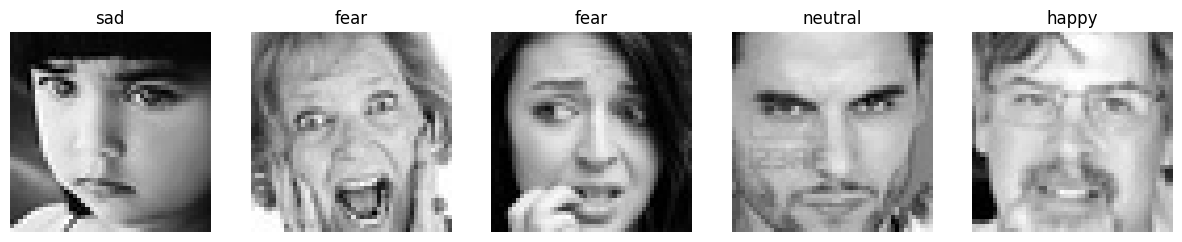

In [8]:
# Mostrar algunas imágenes del conjunto de entrenamiento
def plot_images(images, labels, label_encoder, num_images = 5):
    plt.figure(figsize = (15, 5))
    for i in range(num_images):
        idx = np.random.randint(0, len(images))
        img = images[idx].reshape(48, 48)
        label = label_encoder.inverse_transform([labels[idx]])[0]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap = "gray")
        plt.title(label)
        plt.axis("off")
    plt.show()

plot_images(train_images, encoded_labels, label_encoder)

In [9]:
# Verificar las dimensiones de las imágenes cargadas
train_images.shape

(28821, 48, 48)

### Crear y entrenar el modelo

In [10]:
# Dividir los datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(train_images, encoded_labels, test_size = 0.2, random_state = 42)

In [11]:
# Definir la arquitectura del modelo
model = Sequential([
    Conv2D(32, (3, 3), activation = "relu", input_shape = (48, 48, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation = "relu"),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation = "relu"),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation = "softmax")
])

In [12]:
# Mostrar el resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 839,047 (3.20 MB)

 Trainable params: 839,047 (3.20 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Compilar el modelo
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [14]:
# Usar callbacks
early_stopping = EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True)
model_checkpoint = ModelCheckpoint("best_model.keras", monitor = "val_loss", save_best_only = True)

In [15]:
# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 50,
    batch_size = 32,
    callbacks=[early_stopping, model_checkpoint]
    )

Epoch 1/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.2523 - loss: 1.8028 - val_accuracy: 0.3865 - val_loss: 1.6185
Epoch 2/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.3739 - loss: 1.5986 - val_accuracy: 0.4468 - val_loss: 1.4538
Epoch 3/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.4162 - loss: 1.5033 - val_accuracy: 0.4644 - val_loss: 1.4124
Epoch 4/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.4370 - loss: 1.4546 - val_accuracy: 0.4713 - val_loss: 1.3749
Epoch 5/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.4565 - loss: 1.4021 - val_accuracy: 0.4831 - val_loss: 1.3471
Epoch 6/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.4764 - loss: 1.3636 - val_accuracy: 0.4966 - val_loss: 1.3250
Epoch 7/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.4831 - loss: 1.3428 - val_accuracy: 0.5088 - val_loss: 1.3057
Epoch 8/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.4948 - loss: 1.3113 - 

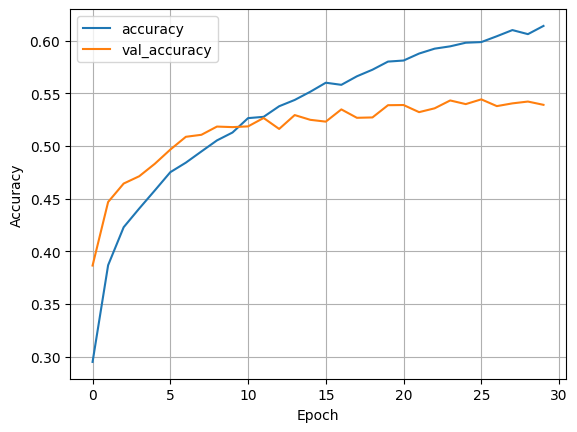

In [16]:
# Gráfica precisión
df_history = pd.DataFrame(history.history)

df_history[["accuracy", "val_accuracy"]].plot()
plt.grid(True)
plt.ylabel("Accuracy")
plt.xlabel("Epoch");

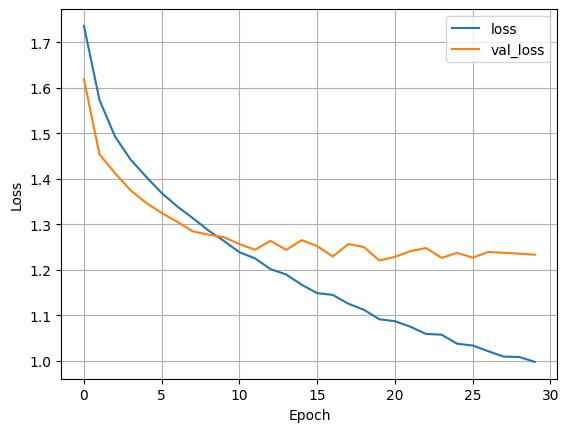

In [17]:
# Gráfica perdida
df_history[["loss", "val_loss"]].plot()
plt.grid(True)
plt.ylabel("Loss")
plt.xlabel("Epoch");

In [18]:
# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5416 - loss: 1.2041
Validation Loss: 1.2205967903137207
Validation Accuracy: 0.5387684106826782


In [19]:
# Generar informe de clasificación
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis = 1)

print(classification_report(y_val, y_val_pred_classes, target_names = label_encoder.classes_))

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

       angry       0.46      0.37      0.41       769
     disgust       0.78      0.08      0.14        93
        fear       0.42      0.30      0.35       823
       happy       0.73      0.77      0.75      1507
     neutral       0.46      0.55      0.50       993
         sad       0.37      0.43      0.40       955
    surprise       0.68      0.73      0.70       625

    accuracy                           0.54      5765
   macro avg       0.56      0.46      0.46      5765
weighted avg       0.54      0.54      0.53      5765



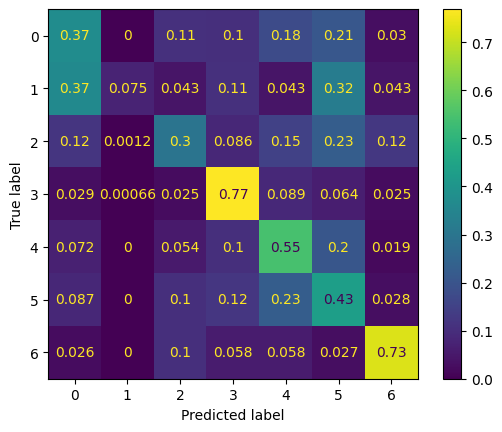

In [20]:
# Generar matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred_classes, normalize = "true");

-----------------------------------------------------------------------------------------------------------------

### Predecir

In [21]:
# Cargar datos
df_test = pd.read_csv("./data/test_set.csv")

# Corregir ruta de las imágenes
df_test["path"] = df_test["id_img"].apply(lambda x : f"data/images/test/{x}.jpg")

# Cargar imágenes de test
test_image_paths = df_test["path"].tolist()
test_images = load_images(test_image_paths)

In [22]:
# Normalizar las imágenes
test_images = test_images / 255

In [23]:
# Hacer predicciones
model.load_weights("best_model.keras")
predictions = model.predict(test_images)
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis = 1))

221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


-----------------------------------------------------------------------------------------------------------------

### Crear submission

In [24]:
df_submission = pd.DataFrame({"id_img" : df_test["id_img"], "label" : predicted_labels})
df_submission.to_csv("submission.csv", index = False)